## Uncertainty estimate in ragmac_xdem

This notebook describes how uncertainty in average elevation change is calculated for all experiments in ragmac_xdem. This is essentially based on [this notebook](https://xdem.readthedocs.io/en/latest/auto_examples/plot_standardization.html) taken from xdem.

This is done in 3 steps:
1. Standardize the elevation difference map, to account for a dependance of the error on other factors than location (e.g. terrain slope, curvature etc)
2. Analyse the spatial variance of the error using variograms
3. Use the two previous results to provide an uncertainty estimate of the glacier mean elevation change.

### Load modules

In [1]:
import os
from ragmac_xdem import files, utils
from ragmac_xdem import dem_postprocessing as pproc

import matplotlib.pyplot as plt
import numpy as np
import xdem

plt.rcParams["image.interpolation"] = "none"


# 0 - First Load input data

Works only after `scripts/main_experiment2.py` has been run successfully.

In [2]:
baltoro_paths = files.get_data_paths("PK_Baltoro")
ref_dem, all_outlines, roi_outlines, roi_mask, stable_mask = utils.load_ref_and_masks(baltoro_paths)
validation_dates = baltoro_paths["validation_dates"]
outdir = os.path.join(baltoro_paths["processed_data"]["directory"], "results_median", )
ddems = pproc.merge_and_calculate_ddems([], validation_dates, ref_dem, outdir=outdir, 
                                        overwrite=False, mode='median')

Loading existing files


### Take the '2012-2019' dh map as an example

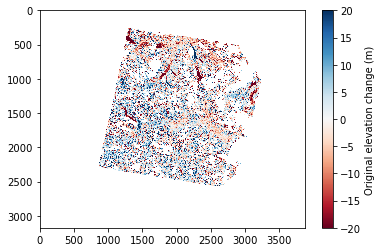

In [3]:
dh = ddems["2012_2019"]
plt.imshow(dh.data.squeeze(), cmap="RdBu", vmin=-20, vmax=20)
cb = plt.colorbar()
cb.set_label("Original elevation change (m)")

# 1- Standardize elevation difference

Errors in elevation difference are related to external parameters, such as terrain slope, aspect or maximum curvature, or possibly image/processing characteristics such as image contrast, radar penetration...

For these reasons, the assumption of homoscedasticity (homogeneity of the variance) needed for geospatial statistics, is not fullfilled. This first need to be corrected.  

To do so, we normalize elevation differences based on two main predictors of the variance: terrain slope and maximum curvature. Other possible predictors are not taken into account here. 

## Compute slope and maximum curvature

In [4]:
slope, planc, profc = xdem.terrain.get_terrain_attribute(
    dem=ref_dem.data, attribute=["slope", "planform_curvature", "profile_curvature"], resolution=ref_dem.res
)
maxc = np.maximum(np.abs(planc), np.abs(profc))


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Plot

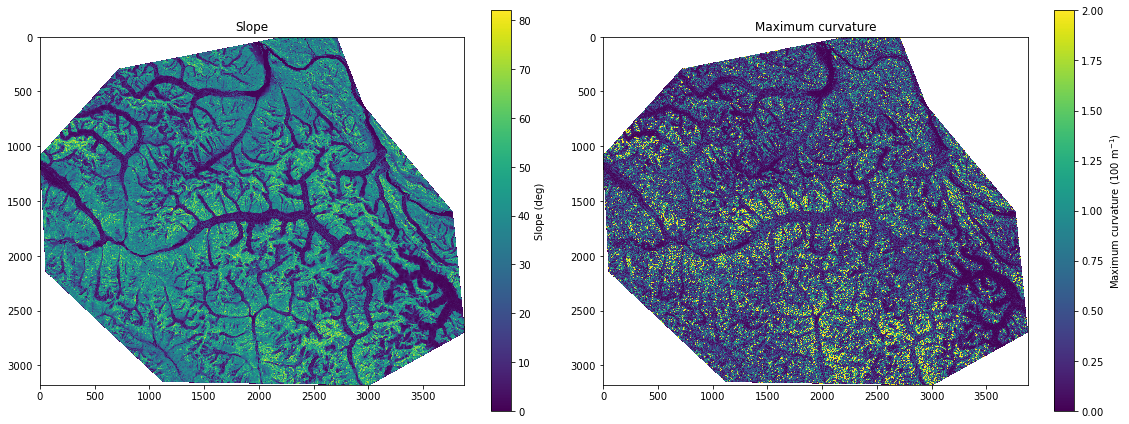

In [5]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
plt.imshow(slope.squeeze())
cb = plt.colorbar()
cb.set_label("Slope (deg)")
plt.title("Slope")
ax2 = plt.subplot(122)
plt.imshow(maxc.squeeze(), vmax=2)
cb = plt.colorbar()
cb.set_label("Maximum curvature (100 m$^{-1}$)")
plt.title("Maximum curvature")
plt.tight_layout()
plt.show()

### Remove values on unstable terrain

In [6]:
dh_arr = dh.data[stable_mask]
slope_arr = slope[stable_mask]
maxc_arr = maxc[stable_mask]

### Remove large outliers

In [7]:
dh_arr[np.abs(dh_arr) > 4 * xdem.spatialstats.nmad(dh_arr)] = np.nan

## Find empirical relationship between error, slope and max curvature

An empirical relationship is searched for between error (assumed equal to elevation differences in stable terrain) and predictive variables, by calculating the average error for various bins of slope and max curvature.

### Define bins for 2D binning
Here we use quantile bins, to try to get bins with roughly uniform sample size, and try to have a finer sampling for extreme slope/curvature values.

In [8]:
custom_bin_slope = np.unique(
    np.concatenate(
        [
            np.nanquantile(slope_arr, np.linspace(0, 0.95, 20)),
            np.nanquantile(slope_arr, np.linspace(0.96, 0.99, 5)),
            np.nanquantile(slope_arr, np.linspace(0.991, 1, 10)),
        ]
    )
)

custom_bin_curvature = np.unique(
    np.concatenate(
        [
            np.nanquantile(maxc_arr, np.linspace(0, 0.95, 20)),
            np.nanquantile(maxc_arr, np.linspace(0.96, 0.99, 5)),
            np.nanquantile(maxc_arr, np.linspace(0.991, 1, 10)),
        ]
    )
)


### Perform 2D (slope, max curve) binning

In [9]:
df = xdem.spatialstats.nd_binning(
    values=dh_arr,
    list_var=[slope_arr, maxc_arr],
    list_var_names=["slope", "maxc"],
    statistics=["count", np.nanmedian, np.nanstd, xdem.spatialstats.nmad],
    list_var_bins=[custom_bin_slope, custom_bin_curvature],
)

### Plots showing the relationship between error,  slope and max curvature

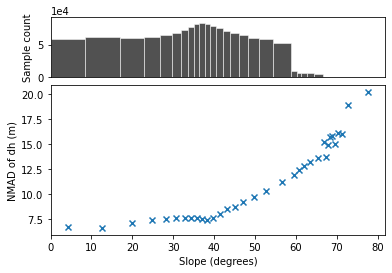

In [10]:
xdem.spatialstats.plot_1d_binning(df, "slope", "nmad", "Slope (degrees)", "NMAD of dh (m)")


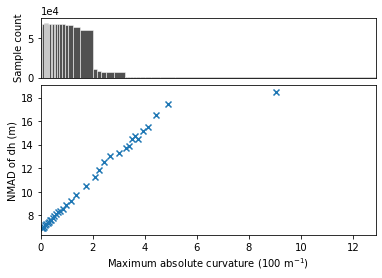

In [11]:
xdem.spatialstats.plot_1d_binning(df, "maxc", "nmad", "Maximum absolute curvature (100 m$^{-1}$)", "NMAD of dh (m)")


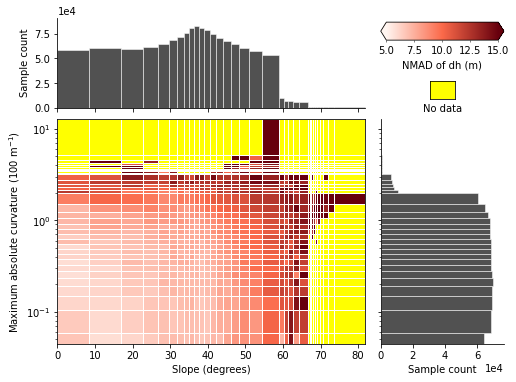

In [12]:
xdem.spatialstats.plot_2d_binning(
    df,
    "slope",
    "maxc",
    "nmad",
    "Slope (degrees)",
    "Maximum absolute curvature (100 m$^{-1}$)",
    "NMAD of dh (m)",
    scale_var_2="log",
    vmin=5,
    vmax=15,
)

#### The plots show that dh error increases with slope and maximum curvature. Now we empirically model that relationship to be able to apply it at any pixel.

## Estimate an empirical relationship, to be applied at each pixel

In [13]:
slope_curv_to_dh_err = xdem.spatialstats.interp_nd_binning(
    df, list_var_names=["slope", "maxc"], statistic="nmad", min_count=30
)

dh_err = slope_curv_to_dh_err((slope, maxc))

### Plot the map of modelled error

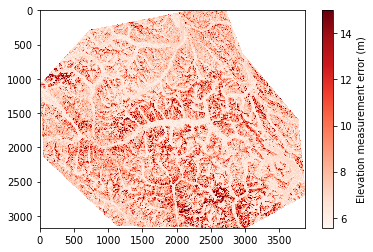

In [14]:
plt.imshow(dh_err.squeeze(), cmap="Reds", vmax=15)
cb = plt.colorbar()
cb.set_label("Elevation measurement error (m)")
plt.show()

#### Here, we see areas of larger errors, i.e. steep and rugged reliefs.

## Finally, standardize the elevation difference error

In [15]:
z_dh = dh.data / dh_err

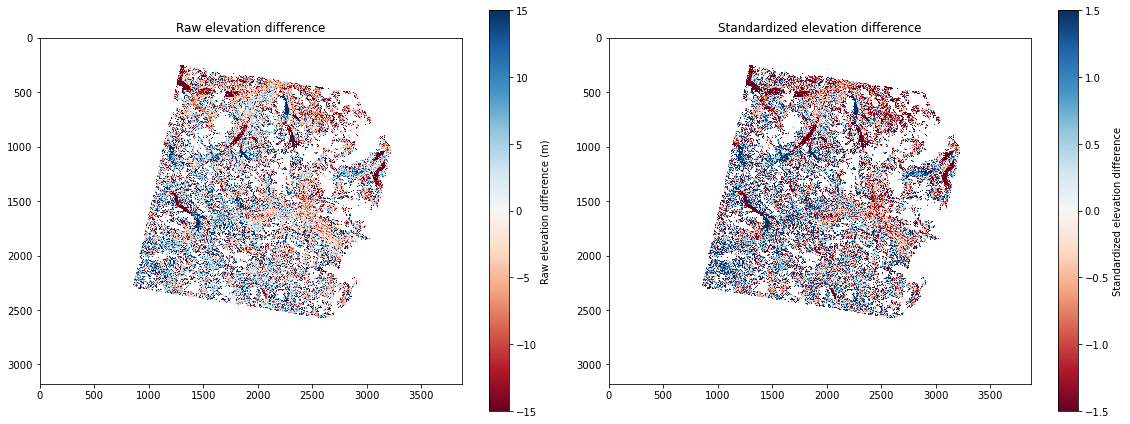

In [16]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
plt.imshow(dh.data.squeeze(), cmap="RdBu", vmin=-15, vmax=15)
cb1 = plt.colorbar()
cb1.set_label("Raw elevation difference (m)")
plt.title("Raw elevation difference")
ax2 = plt.subplot(122)
plt.imshow(z_dh.squeeze(), cmap="RdBu", vmin=-1.5, vmax=1.5)
cb2 = plt.colorbar()
cb2.set_label("Standardized elevation difference")
plt.title("Standardized elevation difference")
plt.tight_layout()
plt.show()

The left panel shows the original elevation difference map, the right panel shows the standardized map.
Apart from the amplitude, the differences are subtle. But the error over the flat glaciers is comparatively increased compared to the one on the steep surrounding peaks. This is because we take into account the spatial variability of the error related to terrain attributes. 

### Remove glacier areas and large outliers

In [17]:
z_dh.data[~stable_mask] = np.nan
z_dh.data[np.abs(z_dh.data) > 4] = np.nan

### Scale-correction for the standardization, to ensure that the standard deviation of the data is exactly 1.


In [18]:
print("Standard deviation before scale-correction: {:.1f}".format(np.nanstd(z_dh.data)))
scale_fac_std = np.nanstd(z_dh.data)
z_dh = z_dh / scale_fac_std
print("Standard deviation after scale-correction: {:.1f}".format(np.nanstd(z_dh.data)))


Standard deviation before scale-correction: 1.2
Standard deviation after scale-correction: 1.0


# 2 - Analyze the spatial variance of the error

### Estimate ranges of spatial correlation of the error, using variogram

We first calculate an empirical variogram, then fit a sum of 2 spherical models (Variable `random_state` is set to make results reproducible from one time to another, despite the random sampling).

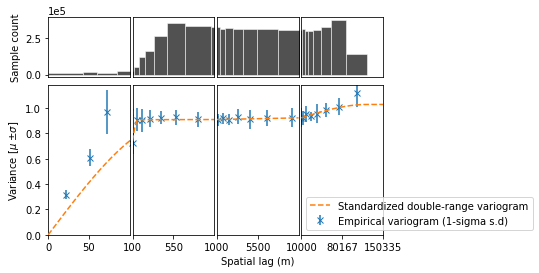

In [19]:
df_vgm = xdem.spatialstats.sample_empirical_variogram(
    values=z_dh.data.squeeze(), gsd=dh.res[0], subsample=50, runs=30, n_variograms=10, n_jobs=4, random_state=42
)

fun, params = xdem.spatialstats.fit_sum_model_variogram(["Sph", "Sph"], empirical_variogram=df_vgm)
xdem.spatialstats.plot_vgm(
    df_vgm,
    xscale_range_split=[100, 1000, 10000],
    list_fit_fun=[fun],
    list_fit_fun_label=["Standardized double-range variogram"],
)


### Get range and sill of each variogram model

In [20]:
print(f"First model - range: {params[0]} m - sill: {params[1]}")
print(f"Second model - range: {params[2]} m - sill: {params[3]}")

First model - range: 159.6240794733491 m - sill: 0.9076563891016937
Second model - range: 122880.00000000022 m - sill: 0.12042965436466235


We find correlation ranges of about 150 m and 122 km. 
The second range seem unexpectedly large (Hugonnet et al. 2021 suggest long-range of about 2-20 km). This might be specific to this elevation change map.

### Calculate the effective number of samples for our ROI glacier

In [21]:
neff = xdem.spatialstats.neff_circ(
    np.sum(roi_outlines.ds["Area"].values)*1e6, [(params[0], "Sph", params[1]), (params[2], "Sph", params[3])]
)
print("Number of effective samples: {:.1f}".format(neff))


Number of effective samples: 9.8


# 3 - Calculate final uncertainty

In [22]:
fac_dh_err = scale_fac_std * np.nanmean(dh_err[roi_mask])
dh_err = fac_dh_err / np.sqrt(neff)

In [23]:
mean_dh = np.nanmean(dh.data[roi_mask])

In [24]:
print(f"Mean elevation change with error bar: {mean_dh} +/- {dh_err}")


Mean elevation change with error bar: -0.5412169098854065 +/- 2.8120769441186986
